In [1]:
include("mdlecturesrc.jl")
myplot()

# Lecture 2: Molecular Dynamics

* Newton's Law
* Integrators
* Discretisation
* Langevin dynamics
* Statistical errors on observables

## Modeling the world

As far as we know, the world works according to the Schrödinger equation:

$$
-i\hbar \frac{\partial \Psi}{\partial t} = \mathcal{H} \Psi
$$

where $\Psi$ is a _wave function_ (or probability amplitude),

$$
\Psi \equiv \Psi(x_1, x_2, x_3, \ldots)\qquad x_i \in \mathrm{R}^3
$$

Take the particles to be electrons and atomic nuclei, then the Hamiltonian $\mathcal{H}$ is

$$
\mathcal{H} = \sum_i \frac{1}{2m_i} \nabla^2_{x_i} + \sum_{ij} \frac{Z_i Z_j}{\left|x_i-x_j\right|}
$$

* The first term gives matter is "wavelike" character, the particles' tendency to spread is inversely proportional to their mass
* The second term is the Coulomb interaction of charges. It is easily observable macroscopically!
* (There is also spin, which is omitted from above for simplicity... wave function is a really a 4-vector ... see Dirac theory)
* Limitation: particles stay the same (below some energy limit, they do!)
* Thus far not contradicted by any experiment

In addition, for Fermions (e.g. electrons), the wave function is _antisymmetric_,

$$
\Psi(\ldots, x_i, \ldots, x_j, \ldots) = - \Psi(\ldots, x_j, \ldots, x_i, \ldots) 
$$


## Hierarchy of approximations

Formal solution of the wave equation is

$$
\Psi(t) = e^{i \mathcal{H} t /\hbar} \Psi_0
$$

So eigenvectors of $\mathcal{H}$ are stationary states of an isolated system.
* For a system that interacts with the environment at temperature $T$, the probability of occupying an eigen(energy)-level with energy $E_i$ follows the Boltzmann distribution,
$$
\\
P(\Psi_i) \propto e^{-E_i/kT}
\\
$$
* Room temperature is _small_, $kT \approx 0.025~\mathrm{eV}$. Typical electronic transitions are on the order of $1~ \mathrm{eV}$, e.g. for visible light $\hbar c/\lambda \approx 2~\mathrm{eV}$

In [41]:
using Physical

h_planck*c_light/(500*(Nano*Meter))/ElectronVolt

2.4796838584008407

* Mass scale of electrons and protons are very different: $ 1~\mathrm{p} \approx 1836~\mathrm{e}$, so electrons are _fast_.

* The Born-Oppenheimer approximation separates the eletronic motion (coordinates: $r$) from nuclear motion (coordinates: $R$)


#### The electronic problem

Nuclei fixed at positions $R_j$, consider electronic wave function $\Psi_\mathrm{el}(r_1,r_2,\ldots)$ with Hamiltonian (units: $\hbar = m_\mathrm{e} = e = 1$)

$$
\mathcal{H}_\mathrm{el} = \frac{1}{2} \sum_i \nabla^2_{r_i} + \sum_{ij} \frac{(-1)Z_j}{\left|R_j-r_i\right|} + \sum_{i i'} \frac{1}{\left|r_i-r_{i'}\right|}
$$

Typically we are interested in the situation in which electrons are relaxed into their ground state, the lowest eigenstate whose eigenvalue we identify with electronic potential energy $V_\mathrm{el}(R_1,R_2,\ldots) \equiv E_0$ 

#### The nuclear problem

Here the wave function is of the nuclear coordinates, $\Psi(R_1,R_2,\ldots)$ with Hamiltonian

$$
\mathcal{H}_\mathrm{el} = \sum_j \frac{1}{2m_j} \nabla^2_{R_j} + \sum_{jj'} \frac{Z_j Z_{j'}}{\left|R_j-R_{j'}\right|} + V_\mathrm{el}(R_1,R_2,\ldots)
$$

* At ambient conditions, the nuclear wave functions do not spread very much, do not overlap, and a separable solution is rather accurate (except for low mass hydrogen...)

$$
\Psi(R_1,R_2,\ldots) \approx \Psi(R_1)\Psi(R_2)\Psi(R_3)\ldots
$$

* The quantum system is reduced to a classical system via the _correspondence principle_

$$
\begin{eqnarray}
p_j &=& \langle \Psi | \nabla_{R_j} | \Psi\rangle \\
q_j &=& \langle \Psi | R_j | \Psi\rangle \\
H &=&  \langle \Psi | \mathcal{H}| \Psi\rangle 
\end{eqnarray}
$$

So the classical Hamiltonian is

$$
H = \sum_j \frac{p_j^2}{2m_j} + \underbrace{\sum_{jj'} \frac{Z_j Z_{j'}}{\left|q_j-q_{j'}\right|} + V_\mathrm{el}(q_1,q_2,\ldots)}_{\textrm{"interatomic potential": } V(q_1,q_2,\ldots)}
$$

Leading to the equations of motion, i.e. Newton's law, 

$$
\begin{eqnarray}
\dot q_j &=& \partial H/\partial p_j \qquad & \left(= p_j / m_j\right)\\
\dot p_j &=& -\partial H/\partial q_j \qquad & \left(= -\partial V/\partial q_j = F_j = m_j \ddot q_j \right)\\
\end{eqnarray}
$$

## Discretise, Integrate

We want to numerically integrate the equations of motion forward in time from a given starting point. Truncating the Taylor expansion,

$$
\begin{eqnarray}
q(t+h) &=& q(t) + h \left.\frac{d q}{d t}\right|_t + O(h^2)\\
p(t+h) &=& p(t) + h \left.\frac{d p}{d t}\right|_t + O(h^2)\\
\end{eqnarray}
$$

Leads to Euler's method,

$$
\begin{eqnarray}
q(t+h) &=& q(t) +  h p(t)/m\\
p(t+h) &=& p(t) +  h F(q(t))\\
\end{eqnarray}
$$

In [42]:
Euler = ( (q,p,F,h) -> ( q+h*p, p+h*F(q) )  ) ;

### Try it on the simple harmonic oscillator

The potential is $V(q) = q^2$, with exact solution (starting from $q(0) = 0$),

$$
\begin{eqnarray}
q(t) &=& p(0) \sin(t)\\
p(t) &=& p(0) \cos(t)\\
\end{eqnarray}
$$

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(0.01, nactions=0),"h",0.01,"0.01",Interact.OptionDict(Any["0.01","0.1","0.5","1.0","2.0"],Dict{Any,Any}("0.01"=>0.01,"0.1"=>0.1,"0.5"=>0.5,"2.0"=>2.0,"1.0"=>1.0)),Any[],Any[])

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=0),"show",1,"Trajectory",Interact.OptionDict(Any["Trajectory","Phasespace","Energy"],Dict{Any,Any}("Energy"=>3,"Trajectory"=>1,"Phasespace"=>2)),Any[],Any[])

Interact.Options{:ToggleButtons,Function}(Signal{Function}(velocityVerletLangevin, nactions=0),"integrator",velocityVerletLangevin,"velocityVerletLangevin",Interact.OptionDict(Any["velocityVerletLangevin","Verlet","Euler","velocityVerlet"],Dict{Any,Any}("velocityVerletLangevin"=>velocityVerletLangevin,"Euler"=>(anonymous function),"Verlet"=>(anonymous function),"velocityVerlet"=>(anonymous function))),Any[],Any[])

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(0.01, nactions=0),"γ",0.01,"0.01",Interact.OptionDict(Any["0.01","0.1","0.5","1.0"],Dict{Any,Any}("0.01"=>0.01,"0.1"=>0.1,"0.5"=>0.5,"1.0"=>1.0)),Any[],Any[])

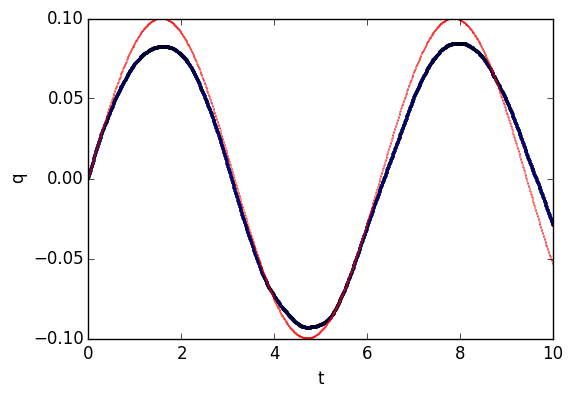

In [46]:
sho_V = (q-> q^2/2)
sho_F = (q-> -q)
p0 = 0.1
kT = 0.01

f = figure()
@manipulate for h in [0.01,0.1,0.5,1.0,2.0],
                show=Dict(:Trajectory => 1, :Phasespace => 2, :Energy => 3),
                integrator=Dict(:Verlet => Verlet,
                                :Euler => Euler,
                                :velocityVerlet => velocityVerlet,
                                :velocityVerletLangevin => velocityVerletLangevin),
                 γ in [0.01, 0.1, 0.5, 1] withfig(f) do 
        
        t = 0:h:1000; q = zeros(t); p = zeros(t); p[1] = p0; Fold = sho_F(q[1])

        for i=2:length(t)
            if integrator === Euler
                q[i],p[i] = Euler(q[i-1],p[i-1], sho_F, h)
            elseif integrator === Verlet
                if i==2
                    q[i],p[i] = Euler(q[i-1], p0, sho_F, h)
                else
                    q[i] = Verlet(q[i-1], q[i-2], sho_F, h)
                    p[i-1] = (q[i]-q[i-2])/(2*h)
                end
            elseif integrator === velocityVerlet
                q[i], p[i], Fold = velocityVerlet(q[i-1], p[i-1], Fold, sho_F, h)
            elseif integrator === velocityVerletLangevin
                q[i], p[i], Fold = velocityVerletLangevin(q[i-1], p[i-1], Fold, sho_F, h, kT, γ)
            end
        end
        r = 1:length(find(t .< 10))
        if show==1
            plot(t[r], q[r], "o-", markersize=2)
            plot(t[r], p0*sin(t[r]), "r.", markersize= (h <0.5 ? 1 : 5))
            xlabel("t"); ylabel("q")
        elseif show==2
            marker = "o-"
            rr = r
            if integrator === velocityVerletLangevin
                r = 1:length(find(t .< 100))
                marker = "."
            end
            plot(q[r], p[r], marker, markersize=2)
            plot(p0*sin(t[rr]), p0*cos(t[rr]), "r.", markersize= (h <0.5 ? 1 : 5) )
            axis("equal"); xlabel("q"); ylabel("p")
        elseif show==3
            Eaxis = kT/4:kT/4:12*kT
            bins,Ehist = hist(map(sho_V, q)+p.^2/2, Eaxis)
            plot(midpoints(bins), Ehist/length(q)/(kT/4), "-")
            plot(Eaxis, exp(-Eaxis/kT)/kT, "r-")
        end
    end
end

### Verlet integrator

Instead of going to higher order in the Taylor expansion, we make it more symmetric

$$
\begin{eqnarray}
q(t-h) &=& q(t) - h \dot q(t) + \frac{h^2}{2} \ddot q(t) + O(h^3)\\
q(t+h) &=& q(t) + h \dot q(t) + \frac{h^2}{2} \ddot q(t) - O(h^3)\\
\end{eqnarray}
$$

Adding the two leads to

$$
q(t+h) = 2 q(t) - q(t-h) + h^2 \ddot q(t) = 2 q(t) - q(t-h) + h^2 F(q(t))/m
$$

In [43]:
Verlet = ( (q,qq,F,h) -> ( 2*q-qq+h^2*F(q) ) ) ;

With this integrator, the velocity is not computed directly, it has to be obtained by finite difference after the step. The following variant called velocity-Verlet avoids this, but needs the force from the previous time step passed in.

$$
\begin{eqnarray}
p(t+\frac{h}{2}) &=& p(t) + \frac{h}{2} F(q(t))\\
q(t+h) &=& q(t) + h p(t+\frac{h}{2})/m \\
p(t+h) &=& p(t+\frac{h}{2}) + \frac{h}{2} F(q(t+h))
\end{eqnarray}
$$

In [44]:
velocityVerlet = (  (q,p,Fq,F,h) -> (ph2 = p+h/2*Fq; qh = q+h*ph2; Fq = F(qh); (qh, ph2+h/2*Fq, Fq) )  )

(anonymous function)

### Langevin dynamics

To model an external heat bath, we introduce Langevin Dynamics, which involves random perturbations on each particle at every time step, and a corresponding frictional force to balance it out. 

The equations of motion are:

$$
\begin{eqnarray}
p(t+\frac{h}{2}) &=& p(t) + \frac{h}{2} F(q(t))\\
q(t+\frac{h}{2}) &=& q(t) + \frac{h}{2} p(t+\frac{h}{2})/m\\
\hat p(t+\frac{h}{2}) &=& e^{-\gamma h} p(t+\frac{h}{2})+\sqrt{kT(1-e^{-2\gamma h})}R(t)\\
q(t+h) &=& q(t+\frac{h}{2}) + \frac{h}{2} \hat p(t+\frac{h}{2})/m \\
p(t+h) &=& \hat p(t+\frac{h}{2}) + \frac{h}{2} F(q(t+h))
\end{eqnarray}
$$

where $T$ is the temperature of the heat bath, and $\gamma$ is the strength of the coupling. The limit of $\gamma \rightarrow 0$ corresponds to the isolated system, and reduces to velocity-Verlet. 

In [45]:
function velocityVerletLangevin(q, p, Fq, F, h, kT, gamma)
    ph2 = p + h/2*Fq
    qh2 = q + h/2*ph2
    pph2= exp(-gamma*h)*ph2 + sqrt(kT*(1-exp(-2*gamma*h)))*(randn(1)[1])
    qh  = qh2 + h/2*pph2
    Fqh = F(qh)
    ph  = pph2 + h/2*Fqh
    (qh, ph, Fqh)
end

velocityVerletLangevin (generic function with 1 method)

## Dynamics of the water monomer

In [47]:
h2o = make_h2o()

h=0.5
kB = 8.6173324e-5 # in eV/K
m = repeat(h2o[:get_masses](), inner=[3])*quippy.units[:MASSCONVERT] #masses to conform to eV, A, fs units
q = vec(h2o[:get_positions]())
Fq = -tip3p.h2o_quad_gradient(q)
p = zeros(q); tmp1 = zeros(q); tmp2 = zeros(q)
@time for i=1:1000
    velocityVerletLangevin!(q, p, Fq, q->(-tip3p.h2o_quad_gradient(q)), m, h, kB*300.0, 0.5, tmp1, tmp2)   
end

  0.023679 seconds (77.02 k allocations: 8.363 MB)


## Dynamics of the water hexamer

In [48]:
h12o6 = make_h12o6()
imolecule_draw(h12o6)

PyObject <IPython.core.display.HTML object>

In [26]:
h=0.5
kB = 8.6173324e-5 # in eV/K
m = repeat(h12o6[:get_masses](), inner=[3])*quippy.units[:MASSCONVERT] #masses to conform to eV, A, fs units
q = vec(h12o6[:get_positions]()')
Fq = -tip3p.gradient(q)
p = zeros(q) ; tmp1 = zeros(q); tmp2 = zeros(q); 
traj = quippy.CInOutput("traj.xyz", quippy.OUTPUT)
N=100001
Ekin = zeros(N); Epot = zeros(N); Rg = zeros(N); w1z = zeros(N)
using ProfileView
Profile.clear()
@time for i=1:N
    Ekin[i] = sum(p.^2./m/2)
    Epot[i] = tip3p.potential(q)
    Rg[i] = h12o6_Rg(q)
    w1z[i] = q[6]-q[3]
    if i%1000 == 1
        h12o6[:set_positions](reshape(q, (3,18))')
        traj[:write](h12o6)
    end 
    if i%10000 == 1
        println("iteration $(i-1)")
    end
    velocityVerletLangevin!(q, p, Fq, q->(-tip3p.gradient(q)), m, h, kB*300.0, 0.5, tmp1, tmp2)   
end
traj[:close]()

iteration 0
iteration 10000
iteration 20000
iteration 30000
iteration 40000
iteration 50000
iteration 60000
iteration 70000
iteration 80000
iteration 90000
iteration 100000
 83.865675 seconds (797.26 M allocations: 120.971 GB, 22.87% gc time)


In [ ]:
h12o6[:set_positions](reshape(q, (3,18))')
imolecule_draw(h12o6)

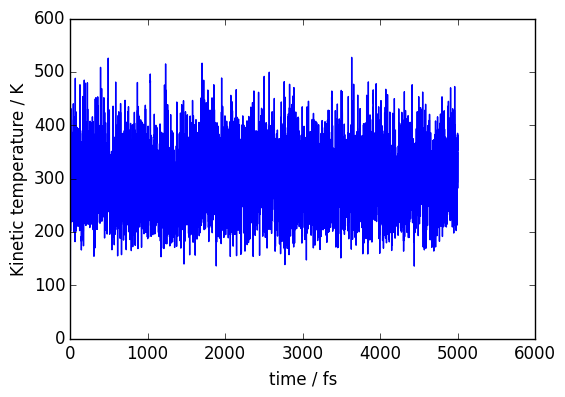

In [6]:
figure()
plot((1:N)*h, Ekin*2/(3*18*kB), "-")
xlabel("time / fs"); ylabel("Kinetic temperature / K")
close(gcf())

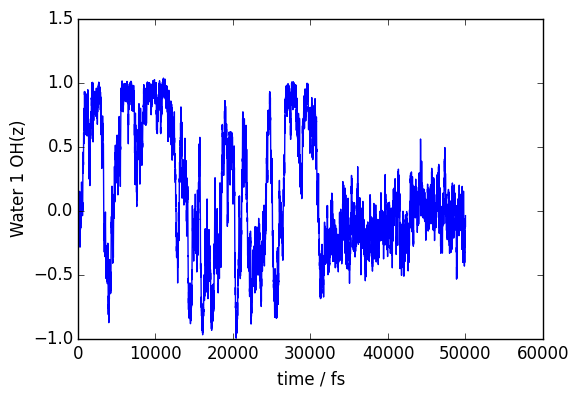

In [27]:
figure()
plot((1:N)*h, w1z, "-")
xlabel("time / fs"); ylabel("Water 1 OH(z)")
close(gcf())

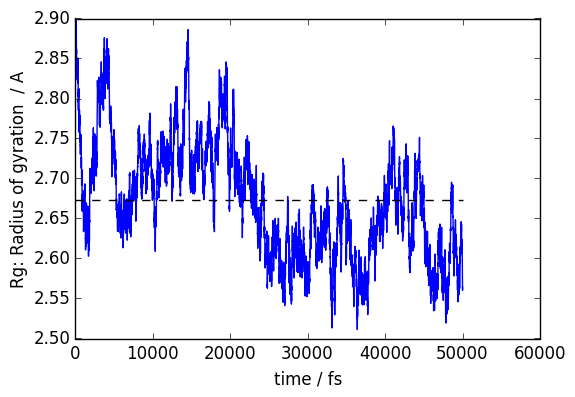

In [28]:
figure()
plot((1:N)*h, Rg, "-", label="Radius of gyration")
plot([1,N]*h, repeat([mean(Rg)], inner=[2]), "k--", label="mean")
xlabel("time / fs"); ylabel("Rg: Radius of gyration  / A")
close(gcf())

## How can we compute the error on the mean? 

### Autocorrelation

In [34]:
aC = fftshift(xcorr(Rg - mean(Rg), Rg - mean(Rg)))[1:length(Rg)÷2]
#aC = fftshift(xcorr(w1z - mean(w1z), w1z - mean(w1z)))[1:length(w1z)÷2]

aC = aC/aC[1]
;

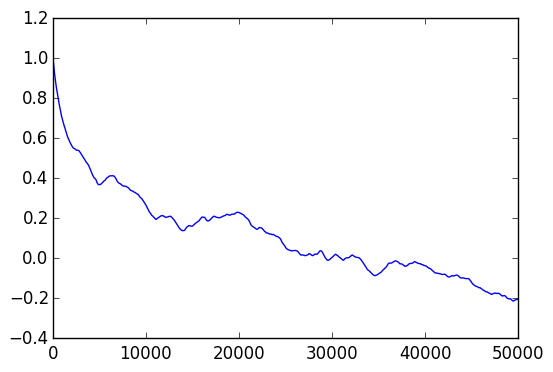

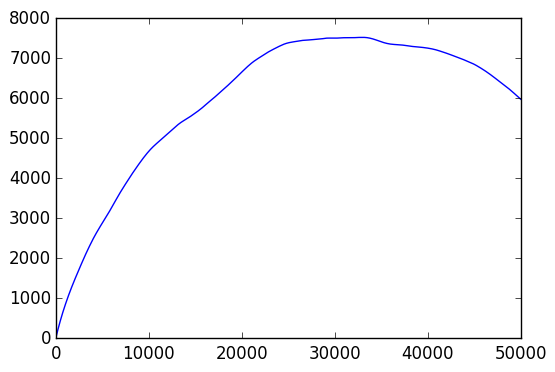

In [35]:
figure()
plot( (1:length(aC)), aC, "-")
close(gcf())

figure()
plot(0.5+cumsum(aC), "-")
close(gcf())

In [40]:
std(Rg), std(Rg)/sqrt(length(Rg)), std(Rg)/sqrt(length(Rg)/(2*(0.5+7000)))

(0.07269196471788761,0.00022987102674886363,0.027199678046422048)